In [1]:
#Create Access to my code
import sys
sys.path.insert(1, '../vidr/')

#Import hte vaedr functions we have created
from vidr import VIDR
from utils import *

#Import important modules
import scanpy as sc
import scgen as scg
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy import stats
from scipy import linalg
from scipy import spatial
from anndata import AnnData
from scipy import sparse
from statannotations.Annotator import Annotator
from matplotlib import pyplot as plt
from matplotlib import cm

import scvi
sc.set_figure_params(dpi = 150)
sns.set_style("dark")

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
#Prepare Data Set
adata = sc.read_h5ad("../data/nault2021_singleDose.h5ad")
cell_types_of_int = ["Hepatocytes - portal", "Hepatocytes - central", "Cholangiocytes", "Stellate Cells", "Portal Fibroblasts", "Endothelial Cells"]
adata = adata[adata.obs['celltype'].isin(cell_types_of_int)]

adata.obs["dose"] = [str(i) for i in adata.obs["Dose"]]

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)

adata = adata[:,adata.var.highly_variable]

Trying to set attribute `.obs` of view, copying.


In [5]:
#Training model
cell = "Hepatocytes - portal"
train_adata, test_adata = prepare_data(adata, "celltype", "dose", cell, "30", normalized = True)
train_adata.obs["cell_dose"] = [f"{j}_{str(i)}" for (i,j) in zip(train_adata.obs["Dose"], train_adata.obs["celltype"])]
model = VIDR(train_adata, linear_decoder = False)
#     model.train(
#     max_epochs=100,
#     batch_size=128,
#     early_stopping=True,
#     early_stopping_patience=25)
    
#     model.save(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt")
vae = model.load(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt/", train_adata)

INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 17791 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 17791 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [6]:
#UMAP Projection of latent space
latent_X = vae.get_latent_representation(adata)
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())
cell_dose = [f"{j}_{str(i)}" for (i,j) in zip(adata.obs["Dose"], adata.obs["celltype"])]
training = ["Train" if i != cell+"_30" else "Test" for i in cell_dose]
latent_adata.obs["Cell_Dose"] = cell_dose
latent_adata.obs["Training Split"] = training

INFO     Received view of anndata, making copy.                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 18865 cells, 5000 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [7]:
from umap import UMAP
from sklearn.decomposition import PCA

In [8]:
delta_dict = {"celltype":[], "pca_coords":[], "pca_delta":[],"delta":[],
              "angle":[], "magnitude":[]}

ct_labels = adata.obs["celltype"]
dose_labels = adata.obs["Dose"]

ct = "Average"
ct_ctrl = latent_adata[(dose_labels == 0)]
ct_treat = latent_adata[(dose_labels == 30)]

ctrl_mean = np.average(ct_ctrl.X, axis = 0)
treat_mean = np.average(ct_treat.X, axis = 0)

delta = treat_mean - ctrl_mean

avg_delta = delta

delta_dict["celltype"].append(ct)
# delta_dict["umap_coords"].append(ct_ctrl.obsm["X_umap"].mean(0))
delta_dict["delta"].append(delta)
# delta_dict["umap_delta"].append(umap_model.transform([delta]).squeeze())
delta_dict["magnitude"].append(np.linalg.norm(delta))
delta_dict["angle"].append(0)

In [9]:
cell_types_of_int = ["Hepatocytes - portal", "Hepatocytes - central", "Cholangiocytes",
                     "Stellate Cells", "Portal Fibroblasts", "Endothelial Cells"]
cell_types_of_int = sorted(cell_types_of_int)
for ct in cell_types_of_int:
    ct_ctrl = latent_adata[((ct_labels == ct) & (dose_labels == 0))]
    ct_treat = latent_adata[((ct_labels == ct) & (dose_labels == 30))]

    ctrl_mean = np.average(ct_ctrl.X, axis = 0)
    treat_mean = np.average(ct_treat.X, axis = 0)

    delta = treat_mean - ctrl_mean
    
    delta_dict["celltype"].append(ct)
#     delta_dict["umap_coords"].append(ct_ctrl.obsm["X_umap"].mean(0))
#     delta_dict["umap_delta"].append(umap_model.transform([delta]).squeeze())
    delta_dict["magnitude"].append(np.linalg.norm(delta))
    delta_dict["delta"].append(delta)
    delta_dict["angle"].append(spatial.distance.cosine(avg_delta, delta))

In [10]:
all_data = np.concatenate([latent_X, np.array(delta_dict["delta"])])

In [11]:
pca_model = PCA(n_components=2).fit(all_data)
X_pca = pca_model.transform(latent_X)
delta_pca = pca_model.transform(np.array(delta_dict["delta"]))

In [12]:
latent_adata.obsm["X_pca"] = X_pca

In [13]:
ct_ctrl = latent_adata[(dose_labels == 0)]
ct_treat = latent_adata[(dose_labels == 30)]
delta_dict["pca_coords"].append(ct_ctrl.obsm["X_pca"].mean(0))

In [14]:
for ct in cell_types_of_int:
    ct_ctrl = latent_adata[((ct_labels == ct) & (dose_labels == 0))]
    ct_treat = latent_adata[((ct_labels == ct) & (dose_labels == 30))]
    delta_dict["pca_coords"].append(ct_ctrl.obsm["X_pca"].mean(0))

In [15]:
delta_dict["pca_delta"] = [i.squeeze() for i in delta_pca]

In [16]:
delta_dict["pca_delta"]

[array([13.414213 , -1.9513074], dtype=float32),
 array([-7.2149463,  0.8025388], dtype=float32),
 array([ 33.189255, -10.649511], dtype=float32),
 array([-15.064152, -11.30965 ], dtype=float32),
 array([-12.964495 ,  -4.2303033], dtype=float32),
 array([-6.2385263, -0.5436661], dtype=float32),
 array([-4.191285 , -0.9070153], dtype=float32)]

# Supplemental Figure 2A

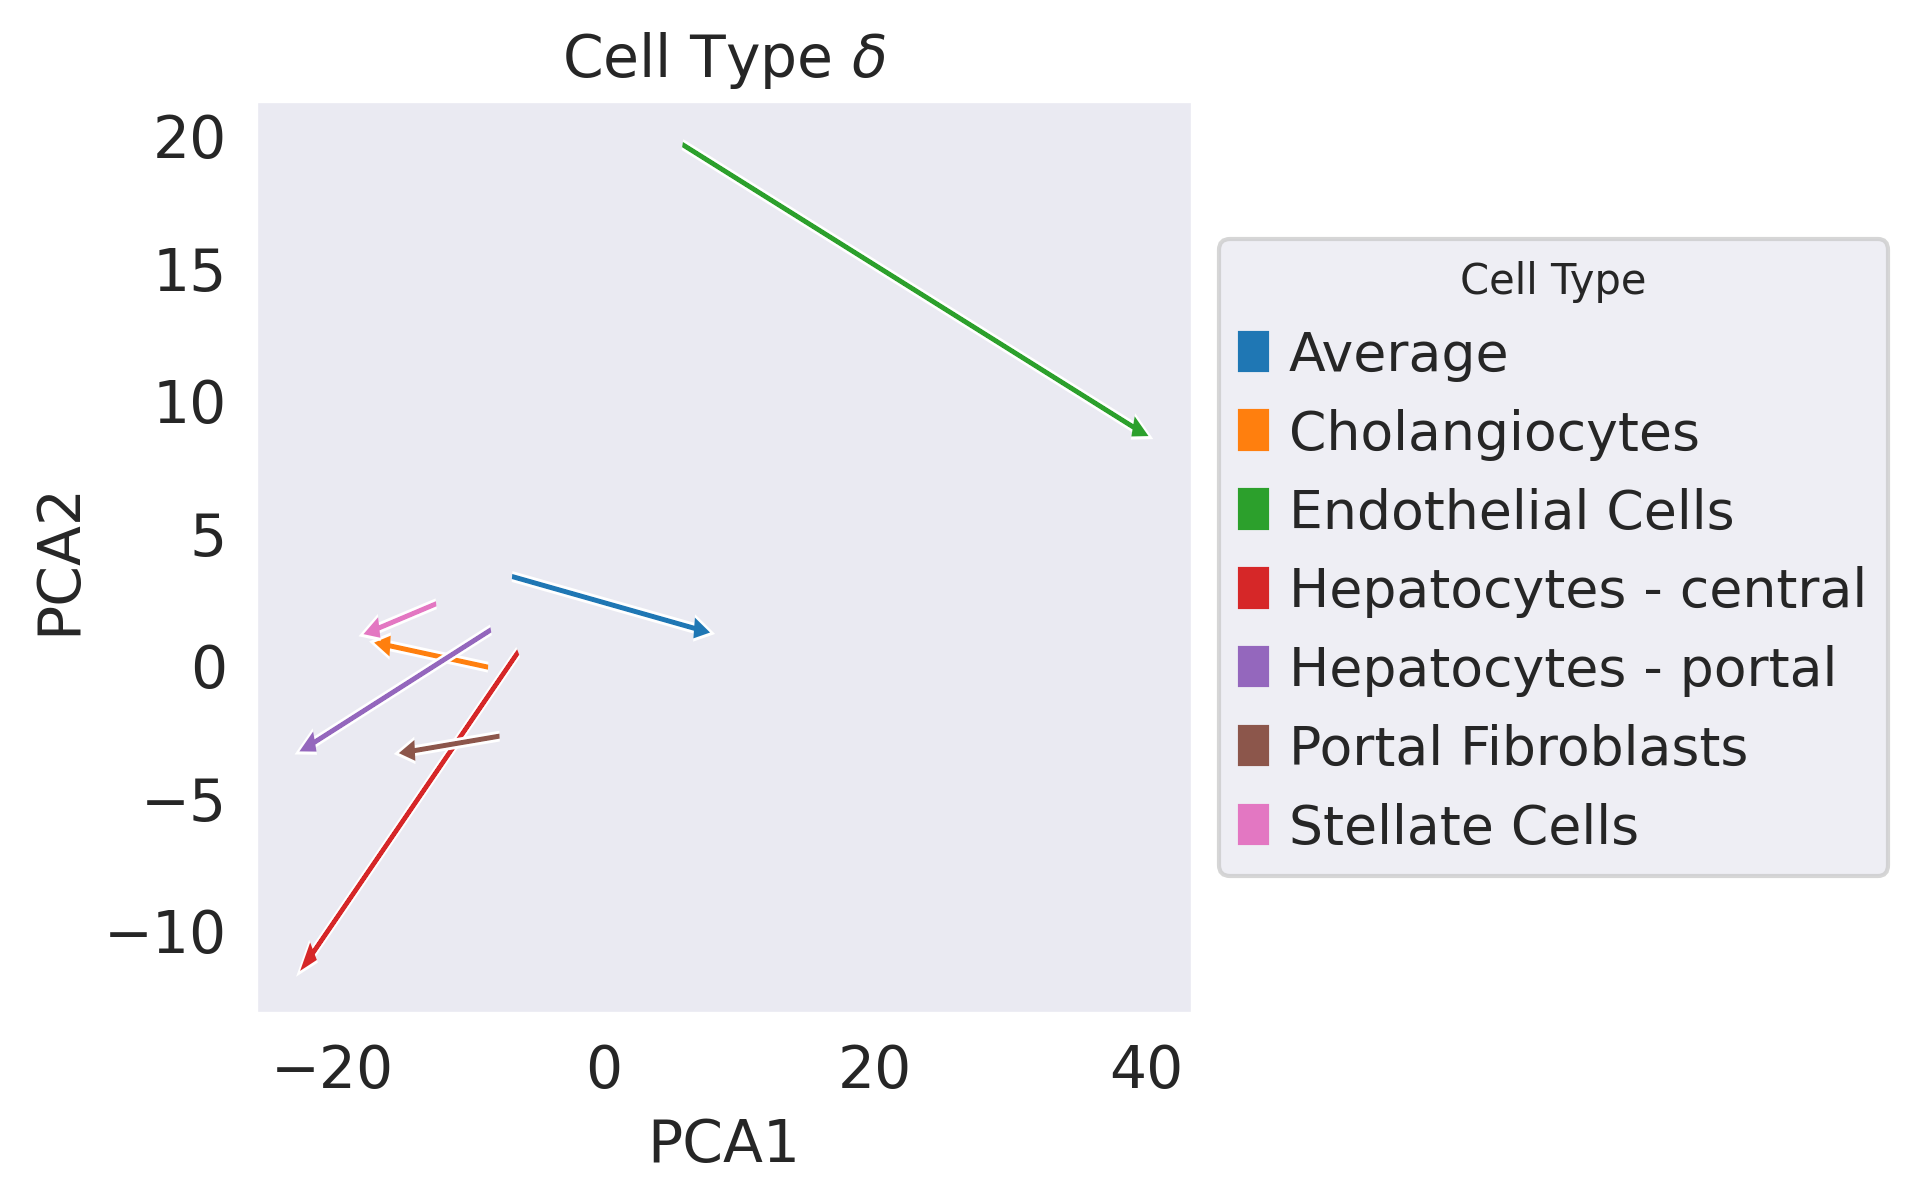

<Figure size 600x600 with 0 Axes>

In [18]:
fig = plt.figure(dpi = 150)
x,y = zip(*delta_dict["pca_coords"])
dx, dy = zip(*delta_dict["pca_delta"])
for i in range(len(x)):
    if i == 0:
        plt.arrow(x[i],y[i],dx[i],dy[i], color = "white", width = 0.25, head_width = 0.75, )
        plt.arrow(x[i],y[i],dx[i],dy[i], color = cm.tab10.colors[i], width = 0.03, head_width = 0.5, label = delta_dict["celltype"][i])
    else:
        plt.arrow(x[i],y[i],dx[i],dy[i], color = "white", width = 0.25, head_width = 0.75)
        plt.arrow(x[i],y[i],dx[i],dy[i], color = cm.tab10.colors[i], width = 0.03, head_width = 0.5, label = delta_dict["celltype"][i])
plt.title("Cell Type $\delta$")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title='Cell Type',title_fontsize=10,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.savefig("../figures/SF2A.svg", bbox_inches="tight")

# Supplemental Figure 2B

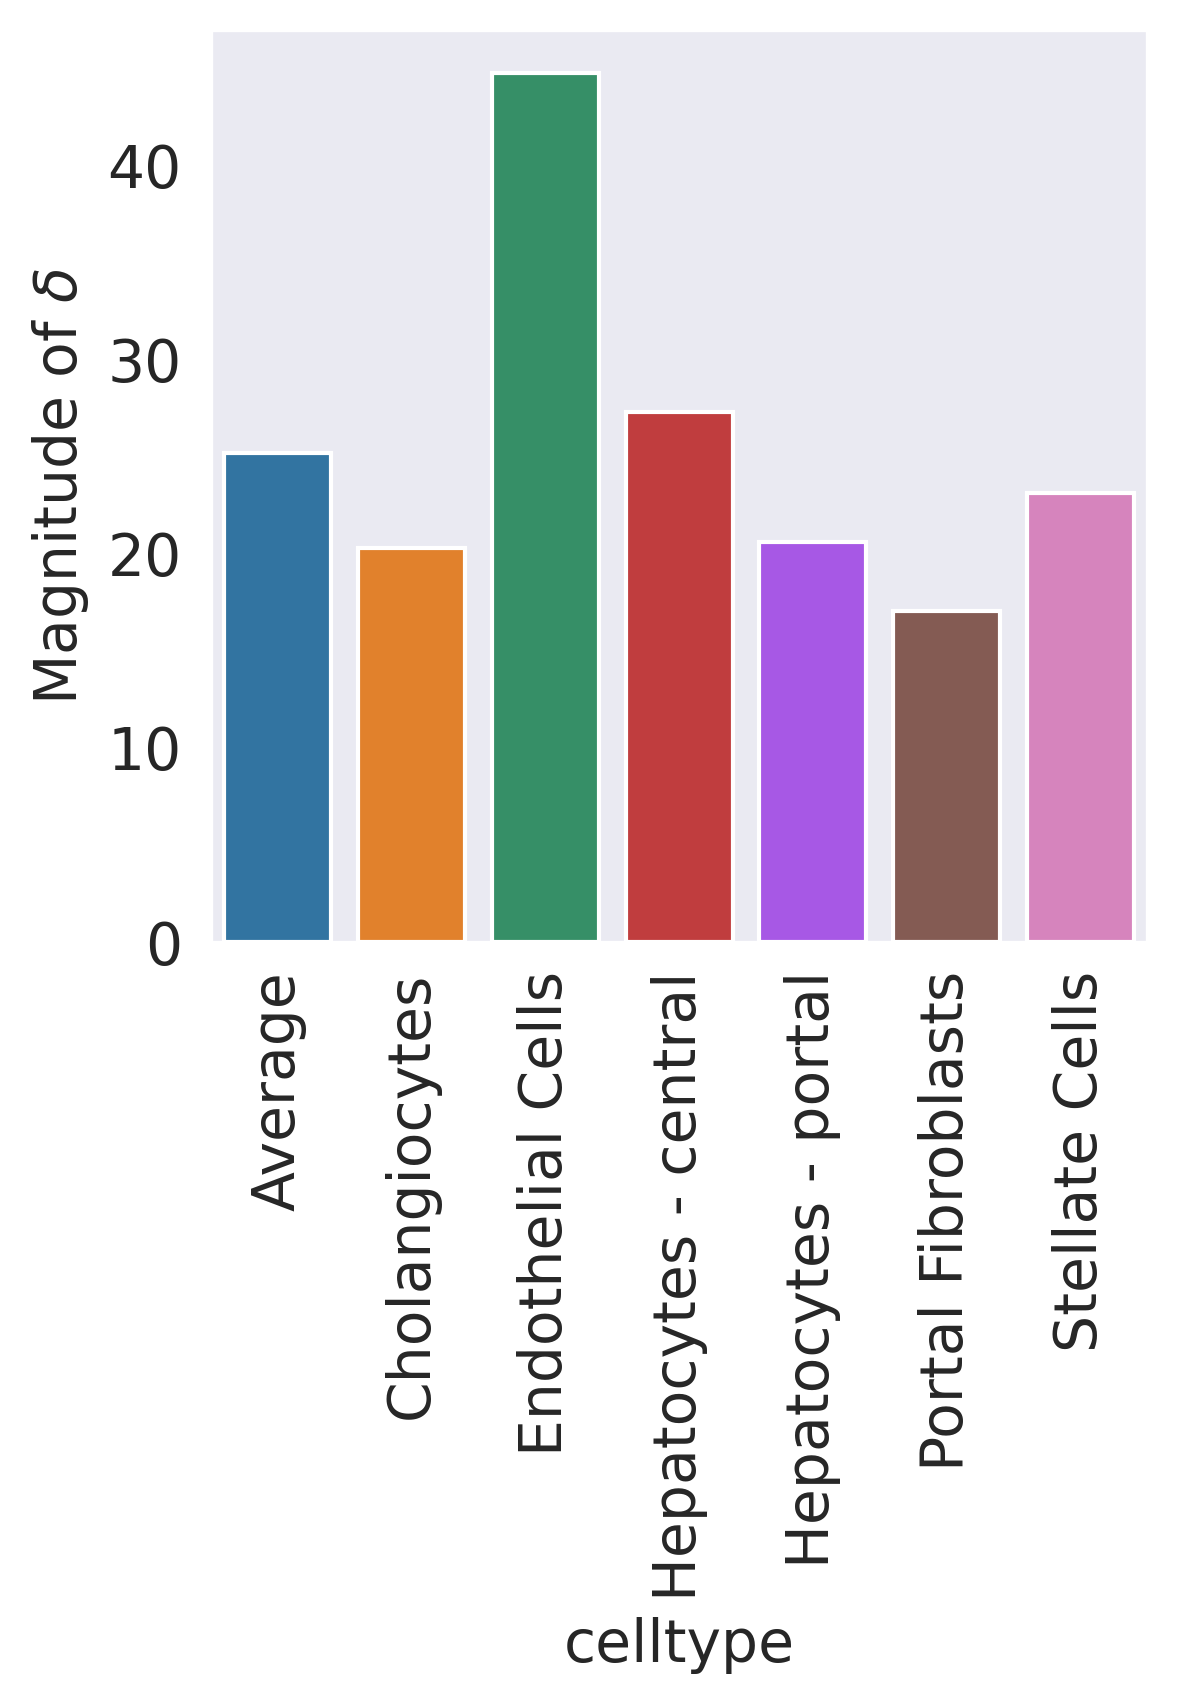

In [19]:
delta_df = pd.DataFrame(delta_dict)
sns.barplot(x = "celltype", y = "magnitude", data = delta_df)
plt.xticks(rotation = 90)
plt.ylabel(r"Magnitude of $\delta$")
plt.savefig("../figures/SF2B1.svg", bbox_inches="tight")

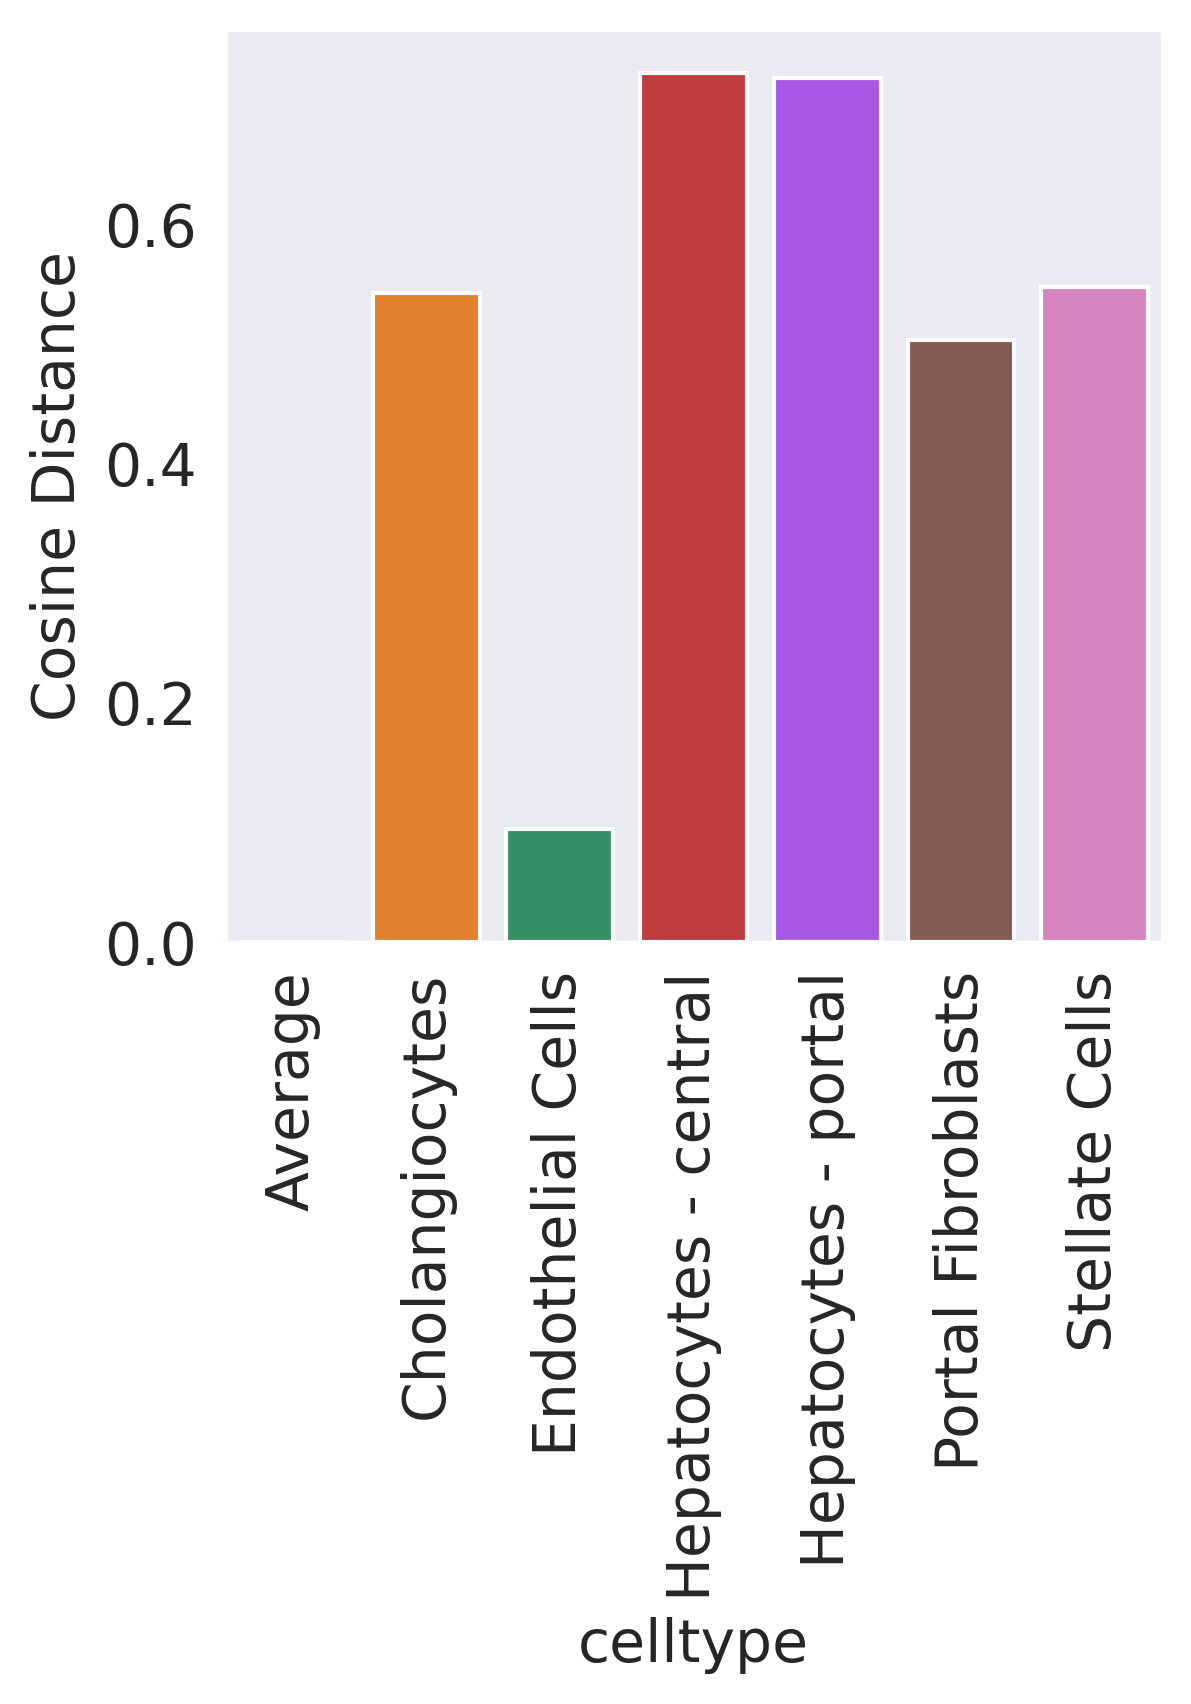

In [20]:
delta_df = pd.DataFrame(delta_dict)
sns.barplot(x = "celltype", y = "angle", data = delta_df)
plt.xticks(rotation = 90)
plt.ylabel(r"Cosine Distance")
plt.savefig("../figures/SF2B2.svg", bbox_inches="tight")

In [ ]:
delat